# generate videos of spiral tips with streams predictive of extinction dynamics
Tim Tyree<br>
3.22.2022

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.2 MB/s eta 0:00:003.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.3 MB/s eta 0:00:00? eta -:--:--
  Preparing metadata (setup.py) ... done
  Created wheel for pycuda: filename=pycuda-2022.1-cp39-cp39-linux_x86_64.whl size=660071 sha256=0950fd44217016ac0e8aef5a00fb1ec529cb0ea4c0d4d40c8c2c27aa4c739f52
  Stored in directory: /home/timothytyree/.cache/pip/wheels/58/86/2e/f57c979b96759028b65c201fca38832ef3494e668d456c26fa
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65020 sha256=7dc75eed5b627fb50c51e3c04a1efbdc0d1ae79b27a61a30604b91c1bcd5b022
  Stored in directory: /home/timothytyree/.cache/pip/wheels/0a/54/93/a4118fdc50f7eb54fce7ce54678967ae2aff53e82bd3762ebb
Successfully built pycuda pytools


In [3]:
from lib.my_initialization import *
from lib.model.minimal_model_cuda import *
from lib import *
import shutil
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [4]:
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()

In [5]:
# 993MiB /  7982MiB
# 7982/993=8.03...>8
npartitions_gpu=1
npartitions=os.cpu_count()-1
assert npartitions>0

# define module

In [6]:
#input: gpu output in cpu memory
#ouput:  dict_out,img,dimg_dt
def measure_system_luo_rudy(img,dimg_dt,V_threshold,**kwargs):
    """
    kwargs may not be conected to anything
    returns dict_out,img,dimg_dt
    
    Example Usage:
dict_out=measure_system_luo_rudy(img,dimg_dt,V_threshold)
    """
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t=9999.,img=img,dimgdt=dimg_dt,level1=V_threshold,level2=0.)#,width=width,height=height)
    return dict_out

In [7]:
#DONE: dev viewer routine_to_png
#input: dict_out,img,dimg_dt,save_dir
#output: save_dir
def routine_to_png_streaming_tips(task):
    dict_out,img,dimg_dt,save_dir=task
    #define constant parameters
    # fontsize=22
    # xy=(0.75, 0.9)
    inch=6
    fontsize=30
    xy=(0.67, 0.9)
    #define constant coordinate mesh for stream generation
    width=200.#pixel
    height=200.#pixel
    DX=0.025#cm/pixel
    #generate plot
    #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
    fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
    ax=fig.add_subplot()
    #plot the mesh
    X_=np.arange(width)
    Y_=np.arange(height)
    X,Y = np.meshgrid(X_, Y_)
    ax.pcolormesh(X, Y, img,vmin=-80,vmax=40,cmap='bone', shading='gouraud')
    #ax.pcolormesh(X, Y, img, ,vmin=-80,vmax=40,cmap='bone', shading='auto')

    #compute vector field #note notes are for LR model
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     ddVdtdx=np.gradient(dimg_dt,axis=0)/DX #not stable in time
#     ddVdtdy=np.gradient(dimg_dt,axis=1)/DX #not stable in time
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX  #appears to be the opposite direction, also unstable at V_threshold=-50
#     ddVdtdy=-np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
    ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
    ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
#     vx=-ddVdtdx #looks good, opposite direction?
#     vy=-ddVdtdy
    vx=ddVdtdx #still looks meh?
    vy=ddVdtdy

    #compute the streamplot
    use_streamplot=False
    if use_streamplot:
        strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
                         density=0.2)#density=0.5)#jumpy#density=2)#way too much 
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
        if use_streamplot:
            start_points = list(zip(x_values,y_values))
            strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                              color="crimson", #"orange", 
                              linewidth=2,
        #                       integration_direction='forward')
        #                       integration_direction='backward')
                              integration_direction='both')
        ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

        if use_streamplot:
            #record the stream for later analysis
            stream_array=strmS.lines.properties()['segments']
            dict_out['stream_array']=stream_array
    
    #complicated formatting
    #add text of label
#     label=f"Vth={V_threshold}"
    if use_streamplot:
        label=r"$-\nabla \partial_tV$"#+'\n'
        ax.annotate(label, xy=xy, 
                xycoords='axes fraction',
    #             xycoords='data',
    #             xycoords='polar',
                fontsize=fontsize,alpha=0.8)
    #(alternative method with small font...)add text box with label
    # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
    # ax.add_artist(anchored_text)
    # anchored_text.set_alpha(0.1)
    # annotating=False
    # if annotating:
    #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
    #     message_string=f"  num. = {n_tips}"
    #     ax.text(.0,.95,time_step_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    #     ax.text(.0,.9,message_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    ax.axis("off")
    ax.axis([0,width,0,height])
    plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
    plt.close();
    return save_dir

# test my one_step method for the Luo-Rudy model

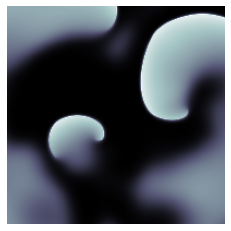

In [8]:
#DONE: load initial condition from the Luo-Rudy model
# ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic008.11.npz"
t=0

txt_lr=load_buffer(ic_fn)
txt_lr.shape


fontsize=16
#plot the field
plt.imshow(txt_lr[...,0],cmap='bone')
plt.axis('off')
plt.show()

In [9]:
get_one_step_explicit_synchronous_splitting_w_Istim

<function lib.controller.controller_LR.get_one_step_explicit_synchronous_splitting_w_Istim(nb_dir, dt=0.01, width=200, height=200, ds=5.0, diffCoef=0.001, Cm=1.0, **kwargs)>

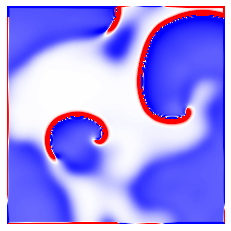

In [10]:
ds=5.
frameno=1
# txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt_lr)
width,height=txt_lr.shape[:2]
V_threshold=-50  #red streams looked unstable 
# V_threshold=-30  #spiral tips look unstable looked unstable 
# V_threshold=-70  #what I used previously in Plotting Local Field of Spiral Tips.ipynb
# dt=0.1 #supports really long termination time...
dt=0.025
# diffCoef=0.0005#0.001#
diffCoef=0.001   #what I used previously in Plotting Local Field of Spiral Tips.ipynb
Cm=1.0
# comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=diffCoef,Cm=Cm)
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)


_,arr39,one_step_lr=get_one_step_explicit_synchronous_splitting_w_Istim(nb_dir,dt=dt,width=200,height=200,ds=5.,diffCoef=diffCoef,Cm=1.)#,**kwargs)

zeros_txt=np.zeros(shape=(width,height))
txt_Istim=zeros_txt.copy()
one_step_lr(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt,txt_Istim)
#TODO: compute the flow map for the Luo-Rudy model
# one_step?
vmax=3
plt.imshow(dVcdt[...,0],cmap='bwr',vmin=-vmax,vmax=vmax)
plt.axis('off')
plt.show()

In [11]:
#input: ic_fn (Luo-Rudy)
#output: txt_init at time t=100 ms
printing=True
txt_lr=load_buffer(ic_fn)
txt=txt_lr.copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
# print(f"{txt.shape=}")
one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,nb_dir,V_threshold=V_threshold,jump_threshold=40,diffCoef=diffCoef)#,**kwargs)
comp_dict_topo_full_color=comp_dict_tips
#reidentify the tips to be tracked
img=inVc[...,0];
dimg_dt=dVcdt[...,0]
dict_tips=comp_dict_tips(img, dimg_dt, t, txt)

t=0
tf=100.#ms
DT=0.025#ms per one_step call
nsteps=int(np.around(tf/DT))
print(f"forward integrating to  tf={tf:.3f} ms...")
for step in range(nsteps):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    #update progressbar
    if printing:
        printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete', length = 50)
#         printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds)', length = 50)
txt_init=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

forward integrating to  tf=100.000 ms...


In [17]:
txt=txt_init.copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)

#measure system
img=inVc[...,0].astype(np.float32)
dimg_dt=dVcdt[...,0].astype(np.float32)
dict_tips=comp_dict_tips(img, dimg_dt, t, txt)
dict_tips['n']=len(dict_tips['x'])

In [18]:
#save ibid as .npz
snapshot_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/fig/lr-snapshot-fig1b.npz'
np.savez_compressed(snapshot_dir, txt_init=txt_init,img=img,dict_tips=dict_tips)
assert os.path.exists(snapshot_dir)

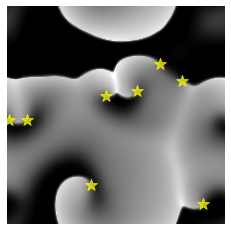

In [68]:
#DONE: visualize spiral tips and verify that they look reasonable
vmin=-80
vmax=10

plt.imshow(img,cmap='gray',vmin=vmin,vmax=vmax)#,shading='gouraud')
plt.scatter(dict_tips['x'],dict_tips['y'],marker='*',s=150,alpha=0.7,color='yellow')
plt.axis('off')
plt.show()

In [12]:
#TODO: visualize streamplot for this snapshot
# heretim
dict_out=dict_tips
# img,dimg_dt,save_dir

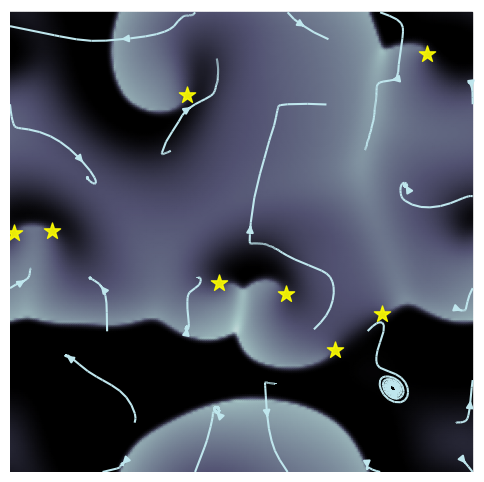

In [13]:
# #DONE: dev viewer routine_to_png
# #input: dict_out,img,dimg_dt,save_dir
# #output: save_dir
# def routine_to_png_streaming_tips(task):
#     dict_out,img,dimg_dt,save_dir=task
#define constant parameters
# fontsize=22
# xy=(0.75, 0.9)
img=inVc[...,0];
# dimg_dt=dVcdt[...,0]
inch=6
fontsize=30
xy=(0.67, 0.9)
#define constant coordinate mesh for stream generation
width=200.#pixel
height=200.#pixel
DX=0.025#cm/pixel
#generate plot
#fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
ax=fig.add_subplot()
#plot the mesh
X_=np.arange(width)
Y_=np.arange(height)
X,Y = np.meshgrid(X_, Y_)
ax.pcolormesh(X, Y, img,vmin=-80,vmax=40,cmap='bone', shading='gouraud')

#compute vector field
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     ddVdtdx=np.gradient(dimg_dt,axis=0)/DX #not stable in time
#     ddVdtdy=np.gradient(dimg_dt,axis=1)/DX #not stable in time
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX  #appears to be the opposite direction, also unstable at V_threshold=-50
#     ddVdtdy=-np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
#     vx=-ddVdtdx #looks good, opposite direction?
#     vy=-ddVdtdy
vx=ddVdtdx #still looks meh?
vy=ddVdtdy

#compute the streamplot
strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
                     density=0.2)#density=0.5)#jumpy#density=2)#way too much 
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
if x_values.shape[0]>0:
    boo=(x_values<width-1.)&(y_values<height-1.)
    x_values=x_values[boo]
    y_values=y_values[boo]
    use_streamplot=False
    if use_streamplot:
        start_points = list(zip(x_values,y_values))
        strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                          color="crimson", #"orange", 
                          linewidth=2,
    #                       integration_direction='forward')
    #                       integration_direction='backward')
                          integration_direction='both')
    ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

    if use_streamplot:
        #record the stream for later analysis
        stream_array=strmS.lines.properties()['segments']
        dict_out['stream_array']=stream_array

if use_streamplot:
    # formatting
    label=r"$-\nabla \partial_tV$"#+'\n'
    ax.annotate(label, xy=xy, 
            xycoords='axes fraction',
            fontsize=fontsize,alpha=0.8)

ax.axis("off")
ax.axis([0,width,0,height])
# plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#     plt.close();
#     return save_dir
plt.show()

In [14]:
t_shift=20#ms
nsteps=int(np.around(t_shift/DT))
print(f"forward integrating to  tf={tf:.3f} ms...")
for step in range(nsteps):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    #update progressbar
    if printing:
        printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete', length = 50)
#         printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds)', length = 50)
t+=t_shift
txt_init_shift=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

forward integrating to  tf=100.000 ms...


In [15]:
txt=txt_init.copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)

#measure system
img=inVc[...,0].astype(np.float32)
dimg_dt=dVcdt[...,0].astype(np.float32)
dict_out=comp_dict_tips(img, dimg_dt, t, txt)
dict_out['n']=len(dict_out['x'])

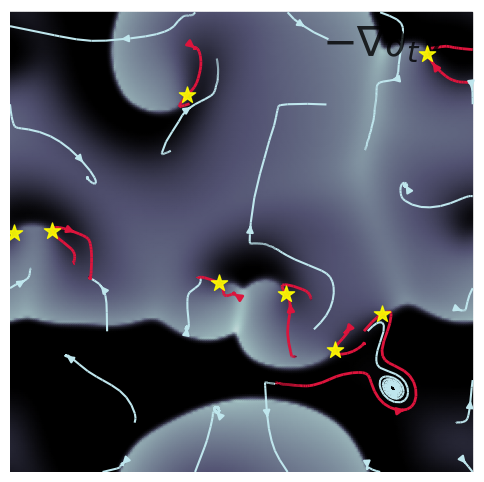

In [16]:
# #DONE: dev viewer routine_to_png
# #input: dict_out,img,dimg_dt,save_dir
# #output: save_dir
# def routine_to_png_streaming_tips(task):
#     dict_out,img,dimg_dt,save_dir=task
#define constant parameters
# fontsize=22
# xy=(0.75, 0.9)
inch=6
fontsize=30
xy=(0.67, 0.9)
#define constant coordinate mesh for stream generation
width=200.#pixel
height=200.#pixel
DX=0.025#cm/pixel
#generate plot
#fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
ax=fig.add_subplot()
#plot the mesh
X_=np.arange(width)
Y_=np.arange(height)
X,Y = np.meshgrid(X_, Y_)
ax.pcolormesh(X, Y, img,vmin=-80,vmax=40,cmap='bone', shading='gouraud')

#compute vector field
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     ddVdtdx=np.gradient(dimg_dt,axis=0)/DX #not stable in time
#     ddVdtdy=np.gradient(dimg_dt,axis=1)/DX #not stable in time
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX  #appears to be the opposite direction, also unstable at V_threshold=-50
#     ddVdtdy=-np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
#     vx=-ddVdtdx #looks good, opposite direction?
#     vy=-ddVdtdy
vx=ddVdtdx #still looks meh?
vy=ddVdtdy

#compute the streamplot
strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
                     density=0.2)#density=0.5)#jumpy#density=2)#way too much 
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
if x_values.shape[0]>0:
    boo=(x_values<width-1.)&(y_values<height-1.)
    x_values=x_values[boo]
    y_values=y_values[boo]
    start_points = list(zip(x_values,y_values))
    strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                          color="crimson", #"orange", 
                          linewidth=2,
    #                       integration_direction='forward')
    #                       integration_direction='backward')
                          integration_direction='both')
    ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

    #record the stream for later analysis
    stream_array=strmS.lines.properties()['segments']
    dict_out['stream_array']=stream_array

# formatting
label=r"$-\nabla \partial_tV$"#+'\n'
ax.annotate(label, xy=xy, 
            xycoords='axes fraction',
            fontsize=fontsize,alpha=0.8)

ax.axis("off")
ax.axis([0,width,0,height])
# plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#     plt.close();
#     return save_dir
plt.show()

## TODO(later): implement one_step method for Luo-Rudy model on the gpu


In [17]:
#TODO(later): implement one_step method for Luo-Rudy model on the gpu
# # from lib.model.minimal_model_cuda import *
# #the following might be needed for the kernel_autotuner.
# # drv.init()

# #define how resources are used
# width  = 200
# height = 200
# block_size_x=10
# block_size_y=10
# threads = (block_size_x,block_size_y,1)
# grid = (int(width/block_size_x, int(height/block_size_y), 1)
# block_size_string = f"#define block_size_x {block_size_x}\n#define block_size_y {block_size_y}\n"

# #set spatial discretization
# DX=0.025 #cm
# # DY=0.025
# DT=0.025 #ms

# #initialize PyCuda and get compute capability needed for compilation
# context = drv.Device(0).make_context()
# devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
# cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

# #load parameters for parameter set 8 for the Fenton-Karma Model
# kwargs = read_parameters_from_json('lib/model/param_set_8.json')
# kwargs['width']=width
# kwargs['height']=height
# kwargs['DX']=DX
# # kwargs['DT']=DT
# # kwargs['DY']=DY

# #define the initial conditions
# Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

# u_initial = Vin.astype(np.float64)
# #initialize auxiliary textures to zero
# v_initial = np.zeros_like(u_initial)
# w_initial = np.zeros_like(u_initial)

# #don't allocate memory many times for the same task!
# #allocate GPU memory for voltage scalar field
# u_old = drv.mem_alloc(u_initial.nbytes)
# u_new = drv.mem_alloc(u_initial.nbytes)

# #allocate GPU memory for v and w auxiliary fields
# v_old = drv.mem_alloc(v_initial.nbytes)
# v_new = drv.mem_alloc(v_initial.nbytes)
# w_old = drv.mem_alloc(w_initial.nbytes)
# w_new = drv.mem_alloc(w_initial.nbytes)

# # explicit time integration up to 5 seconds in steps of size 0.025 ms
# kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
# iterations = 10**5

# #setup thread block dimensions and compile the kernel
# mod = SourceModule(block_size_string+kernel_string)
# time_step_kernel = mod.get_function("time_step_kernel")

# #create events for measuring performance
# start = drv.Event()
# end = drv.Event()

# #move the data to the GPU
# drv.memcpy_htod(u_old, u_initial)
# drv.memcpy_htod(u_new, u_initial)
# drv.memcpy_htod(v_old, v_initial)
# drv.memcpy_htod(v_new, v_initial)
# drv.memcpy_htod(w_old, w_initial)
# drv.memcpy_htod(w_new, w_initial)

# #call the GPU kernel 2*iterations times and measure performance
# context.synchronize()
# start.record()
# for i in range(iterations):
#     time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
#     time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
# end.record()
# context.synchronize()
# runtime = end.time_since(start)
# print(f"{iterations*2} time steps took {runtime:.0f} ms.")

# #copy the result from the GPU to Python for plotting
# gpu_result_u = np.zeros_like(u_initial)
# drv.memcpy_dtoh(gpu_result_u, u_old)
# gpu_result_v = np.zeros_like(v_initial)
# drv.memcpy_dtoh(gpu_result_v, v_old)
# gpu_result_w = np.zeros_like(w_initial)
# drv.memcpy_dtoh(gpu_result_w, w_old)

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
# ax1.imshow(u_initial)
# ax1.set_title("Initial Conditions\n$u_0$")
# ax2.imshow(gpu_result_u)
# ax2.set_title("Final Result From GPU\n$u$")

# ax3.imshow(v_initial)
# ax3.set_title("$v_0$")
# ax4.imshow(gpu_result_v)
# ax4.set_title("$v$")

# ax5.imshow(w_initial)
# ax5.set_title("$w_0$")
# ax6.imshow(gpu_result_w)
# ax6.set_title("$w$")
# plt.show()
# print_dict(kwargs)

# dev

In [18]:
from lib.viewer.viewer_cluster import *

In [19]:
# one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [20]:
# #default for luo-rudy
# # diffCoef=0.0005
# diffCoef=0.001

DT=dt
DT

0.025

In [21]:
# num_steps=22
# txt.astype(np.float64)
# txt_Istim=np.zeros_like(txt)
# forward_integrate_kernel=get_forward_integrate_kernel(nb_dir,dt,width,height,ds,stream,diffCoef=0.001,Cm=1.)
# forward_integrate_kernel(txt,txt_Istim, num_steps)

In [22]:
# load an initial conditions and integrate forward 100ms
# NOTES on runtime with the Luo-Rudy model: 
#simulating 1 termination event took 45 minutes
#1 movie generation took 1 hour total including simulation time
printing=True

ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/'
# ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-out/'
# ic_fn='ic200x200.3.80.npz'
# ic_fn='ic200x200.2.80.npz'
# ic_fn_lst=["ic008.11.npz"]
# ic_fn_lst=["ic008.11.npz","ic017.31.npz",  "ic019.23.npz"]

# #make a list of a bunch of initial conditions from the LR model
ic_fn_lst=["ic002.31.npz",  "ic004.11.npz",  "ic005.33.npz",  "ic009.12.npz",  "ic011.33.npz",  "ic015.31.npz",  "ic017.23.npz",  "ic019.21.npz",
"ic002.32.npz",  "ic004.12.npz",  "ic006.11.npz",  "ic009.31.npz",  "ic012.11.npz",  "ic015.32.npz",  ]# "ic019.23.npz"]#"ic017.31.npz", 


In [23]:
testing=True
if testing:
    ic_fn=ic_fn_lst[0]
    ic_dir=os.path.join(ic_folder,ic_fn)
    if printing:
        print(f"ic_dir='{ic_dir}'")

    #load ic and verify that it contains spiral tips
    txt=load_buffer(ic_dir).astype(np.float64)

    #define the initial conditions
    inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    width_,height_=txt.shape[:2]
    assert (width_==width)
    assert (height_==height)

    t=0
    tf=100.#ms
#     DT=0.025#ms per one_step call
    nsteps=int(np.around(tf/DT))
    #print(f"forward integrating to  tf={tf:.3f} ms...")
    # iterations = 67
    if printing:
        print(f"forward integrating to tf={tf:.3f} ms (iterations={nsteps})...")
    for step in range(nsteps):
        one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
        #update progressbar
        if printing:
            printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete', length = 50)
    #stack txt
    txt_init=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt) #may not be used

    #record final time as new time
    t=tf

    compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
    img=inVc[...,0].astype(np.float32)
    dimg_dt=dVcdt[...,0].astype(np.float32)
#     #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimg_dt,level1=V_threshold,level2=0.)
#     print_dict(dict_out)

#     #measure system
#     img=inVc[...,0].astype(np.float32)
#     dimg_dt=dVcdt[...,0].astype(np.float32)
#     dict_out=comp_dict_tips(img, dimg_dt, t, txt_init)
#     dict_out['n']=len(dict_out['x'])
    #print_dict(dict_out)
    if dict_out['n']>0:
        #generate results for this set of initial conditions
        save_every=67 #leads to exactly a 10/1.05 ~10X slowdown
        save_every=22 #~30X slowdown
        fps=60 #i checked the ffmpeg routine
        # video_duration=30 #seconds
        video_duration=15 #seconds
        pause_after_termination_duration=1. #second
        accumulated_time_after_termination=0.
        #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time

        #time evolve txt on gpu saving to cpu once every 67 time steps
        iterations=save_every
        number_frames=np.around(video_duration*fps)
        nsteps=number_frames
        t_final=tf+DT*iterations*nsteps
        if printing:
            print(f"system initialized at time: {t} ms")
            print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
            print(f"forward integrating to tf={t_final/1e3} seconds...")
        dict_out_lst=[]
        img_lst=[]
        dimg_dt_lst=[]
        start = time.time()
        for step in range(nsteps):
            for i in range(iterations):
                one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

            #measure
            img=inVc[...,0].astype(np.float32)
            dimg_dt=dVcdt[...,0].astype(np.float32)
            dict_out=compute_all_spiral_tips(t,img,dimg_dt,level1=V_threshold,level2=0.)
#this method produces nice results, but crashes
#             txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt) #may not be used
#             dict_out=comp_dict_tips(img, dimg_dt, t, txt)

            #dict_out=measure_system_luo_rudy(img,dimg_dt,V_threshold)
            #update time
            t=(tf+DT*step*iterations)*0.001 #seconds
            dict_out['t']=t

            #record
            dict_out_lst.append(dict_out)
            img_lst.append(img)
            dimg_dt_lst.append(dimg_dt)
            #update progressbar
            
            dict_out['n']=len(dict_out['x'])
            if printing:
                n=dict_out['n']
                printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds, num. tips:{n})', length = 50)
            if n==0:
                #the number of tips is zero
                accumulated_time_after_termination+=DT*iterations
                if accumulated_time_after_termination>pause_after_termination_duration:
                    # break the inner loop
                    break
            else:
                # continue if the inner loop wasn't broken
                continue
            # inner loop was broken, break the outer
            break

        runtime = time.time() - start
        if printing:
            print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
        # beep(1)

        #generate movie of data currently in virtual memory
        dump_cache=True
        save_folder = os.path.join(nb_dir,f'Figures/mov')
        #dump save_folder if it already exists
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        assert (os.path.exists(save_folder))
        if dump_cache:
            shutil.rmtree(save_folder)
            print(f"dumped cache at {save_folder}")
            os.mkdir(save_folder)

        task_lst=[]
        for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
            save_fn=f"img{frameno:07d}.png"
            save_dir=os.path.join(save_folder,save_fn)
            task=dict_out,img,dimg_dt,save_dir
            task_lst.append(task)
        task_lst.pop(-1)
        if printing:
            print(f"added {len(task_lst)} tasks to task_lst")

        testing=False
        if testing:
            task_index=-100
            task = task_lst[task_index]
            routine_to_png_streaming_tips(task)
            if printing:
                print(task[-1])

        if printing:
            print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
            print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
            print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
            #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time


        #this took ?? hours for 16 trials
        start=time.time()
        if printing:
            print(f"generating {len(task_lst)} .png files over {npartitions} cores...")
        retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
        if printing:
            print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
        #beep(2)
        #NOTE: the following was much slower
        # #concatenate the folder of png files to a video
        # os.chdir(f"{nb_dir}/../vid/src")
        # !./concat_folder_png.sh
        # if printing:
        #     print(f"V_threshold={V_threshold}")
        # beep(3)
        #concatenate the folder of png files to a video
        os.chdir(f"{nb_dir}/../vid/src")
        os.system("./concat_folder_png.sh");
        #copy output movie to a file uniquely named for this recording session
        # fn=ic_fn
        fn=os.path.basename(ic_dir)
        save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
        os.chdir(f"{nb_dir}/../vid/mov")
        folder=f'streaming_tips_luo_rudy_diffCoef_{diffCoef}'
        if not os.path.exists(folder):
            os.mkdir(folder)
        save_mov_dir=os.path.join(folder,save_mov_fn)
        os.system(f"cp out.mov {save_mov_dir}")
        # beep(3)
        if printing:
            print(f"{os.path.abspath(save_mov_fn)}")
        #save dict_out_lst to .pkl in new folder in Data/
        save_pkl_folder=os.path.join(ic_folder,'..',folder)
        if not os.path.exists(save_pkl_folder):
            os.mkdir(save_pkl_folder)
        save_pkl_fn=fn.replace('.npz','.pkl')
        save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
        save_to_pkl(save_pkl_dir,dict_out_lst)
        print(f"save_pkl_dir='{save_pkl_dir}'")
        print(f"save_mov_dir='{save_mov_dir}'")

ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic002.31.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████--------------------------------| 37.3% Complete (t=0.284 seconds, num. tips:0))
total run time: 361 seconds for ic002.31.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 335 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov and enter:
*** ls | wc -l ***
estimated run time for plotting ~3.1 minutes...
estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...
generating 335 .png files over 11 cores...
the apparent run time for plotting was 1

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

/home/timothytyree/Documents/GitHub/care/vid/mov/ic002.31_streaming_tips.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../streaming_tips_luo_rudy_diffCoef_0.001/ic002.31.pkl'
save_mov_dir='streaming_tips_luo_rudy_diffCoef_0.001/ic002.31_streaming_tips.mov'


frame= 1045 fps=253 q=-1.0 Lsize=     465kB time=00:00:17.36 bitrate= 219.5kbits/s dup=1 drop=0 speed= 4.2x    
video:447kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.805897%
[libx264 @ 0x563545174dc0] frame I:5     Avg QP:26.46  size:  3662
[libx264 @ 0x563545174dc0] frame P:290   Avg QP:28.37  size:  1006
[libx264 @ 0x563545174dc0] frame B:750   Avg QP:25.30  size:   196
[libx264 @ 0x563545174dc0] consecutive B-frames:  2.2%  2.9% 10.3% 84.6%
[libx264 @ 0x563545174dc0] mb I  I16..4: 52.8% 46.3%  0.9%
[libx264 @ 0x563545174dc0] mb P  I16..4:  2.8%  1.2%  0.0%  P16..4: 11.0%  0.5%  0.1%  0.0%  0.0%    skip:84.5%
[libx264 @ 0x563545174dc0] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  5.6%  0.0%  0.0%  direct: 0.0%  skip:94.3%  L0:26.9% L1:73.0% BI: 0.1%
[libx264 @ 0x563545174dc0] 8x8 transform intra:34.5% inter:91.3%
[libx264 @ 0x563545174dc0] coded y,uvDC,uvAC intra: 2.4% 10.7% 0.4% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x563545174dc0] i16 v,h,dc,p: 30% 19% 

In [24]:
def routine_gener_movie_lr(ic_fn):
    try:
        ic_dir=os.path.join(ic_folder,ic_fn)
        if printing:
            print(f"ic_dir='{ic_dir}'")

        #load ic and verify that it contains spiral tips
        txt=load_buffer(ic_dir).astype(np.float64)

        #define the initial conditions
        inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
        width_,height_=txt.shape[:2]
        assert (width_==width)
        assert (height_==height)

        t=0
        tf=100.#ms
    #     DT=0.025#ms per one_step call
        nsteps=int(np.around(tf/DT))
        #print(f"forward integrating to  tf={tf:.3f} ms...")
        # iterations = 67
        if printing:
            print(f"forward integrating to tf={tf:.3f} ms (iterations={nsteps})...")
        for step in range(nsteps):
            one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
            #update progressbar
            if printing:
                printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete', length = 50)
        #stack txt
        txt_init=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt) #may not be used

        #record final time as new time
        t=tf

        #compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
    #     img=inVc[...,0].astype(np.float32)
    #     dimg_dt=dVcdt[...,0].astype(np.float32)
    #     #compute spiral tip locations
    #     dict_out=compute_all_spiral_tips(t,img,dimg_dt,level1=V_threshold,level2=0.)
    #     print_dict(dict_out)

        #measure system
        img=inVc[...,0].astype(np.float32)
        dimg_dt=dVcdt[...,0].astype(np.float32)
        #dict_out=comp_dict_tips(img, dimg_dt, t, txt_init)
        dict_out=compute_all_spiral_tips(t,img,dimg_dt,level1=V_threshold,level2=0.)
        #dict_out['n']=len(dict_out['x'])
        dict_out['n']=len(dict_out['x'])
        #print_dict(dict_out)
        if dict_out['n']>0:
            #generate results for this set of initial conditions
            save_every=67 #leads to exactly a 10/1.05 ~10X slowdown
            save_every=22 #~30X slowdown
            fps=60 #i checked the ffmpeg routine
            # video_duration=30 #seconds
            video_duration=15 #seconds
            pause_after_termination_duration=1. #second
            accumulated_time_after_termination=0.
            #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time

            #time evolve txt on gpu saving to cpu once every 67 time steps
            iterations=save_every
            number_frames=np.around(video_duration*fps)
            nsteps=number_frames
            t_final=tf+DT*iterations*nsteps
            if printing:
                print(f"system initialized at time: {t} ms")
                print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
                print(f"forward integrating to tf={t_final/1e3} seconds...")
            dict_out_lst=[]
            img_lst=[]
            dimg_dt_lst=[]
            start = time.time()
            for step in range(nsteps):
                for i in range(iterations):
                    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

                #measure
                img=inVc[...,0].astype(np.float32)
                dimg_dt=dVcdt[...,0].astype(np.float32)
                dict_out=compute_all_spiral_tips(t,img,dimg_dt,level1=V_threshold,level2=0.)
                dict_out['n']=len(dict_out['x'])
#this method produces nice results, but crashes
#             txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt) #may not be used
#             dict_out=comp_dict_tips(img, dimg_dt, t, txt)

                #dict_out=measure_system_luo_rudy(img,dimg_dt,V_threshold)
                #update time
                t=(tf+DT*step*iterations)*0.001 #seconds
                dict_out['t']=t

                #record
                dict_out_lst.append(dict_out)
                img_lst.append(img)
                dimg_dt_lst.append(dimg_dt)
                #update progressbar
#                 dict_out['n']=len(dict_out['x'])
                if printing:
                    n=dict_out['n']
                    printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds, num. tips:{n})', length = 50)
                if n==0:
                    #the number of tips is zero
                    accumulated_time_after_termination+=DT*iterations
                    if accumulated_time_after_termination>pause_after_termination_duration:
                        # break the inner loop
                        break
                else:
                    # continue if the inner loop wasn't broken
                    continue
                # inner loop was broken, break the outer
                break

            runtime = time.time() - start
            if printing:
                print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
            # beep(1)

            #generate movie of data currently in virtual memory
            dump_cache=True
            save_folder = os.path.join(nb_dir,f'Figures/mov')
            #dump save_folder if it already exists
            if not os.path.exists(save_folder):
                os.mkdir(save_folder)
            assert (os.path.exists(save_folder))
            if dump_cache:
                shutil.rmtree(save_folder)
                print(f"dumped cache at {save_folder}")
                os.mkdir(save_folder)

            task_lst=[]
            for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
                save_fn=f"img{frameno:07d}.png"
                save_dir=os.path.join(save_folder,save_fn)
                task=dict_out,img,dimg_dt,save_dir
                task_lst.append(task)
            task_lst.pop(-1)
            if printing:
                print(f"added {len(task_lst)} tasks to task_lst")

            testing=False
            if testing:
                task_index=-100
                task = task_lst[task_index]
                routine_to_png_streaming_tips(task)
                if printing:
                    print(task[-1])

            if printing:
                print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
                print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
                print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
                #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time


            #this took ?? hours for 16 trials
            start=time.time()
            if printing:
                print(f"generating {len(task_lst)} .png files over {npartitions} cores...")
            retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
            if printing:
                print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
            #beep(2)
            #NOTE: the following was much slower
            # #concatenate the folder of png files to a video
            # os.chdir(f"{nb_dir}/../vid/src")
            # !./concat_folder_png.sh
            # if printing:
            #     print(f"V_threshold={V_threshold}")
            # beep(3)
            #concatenate the folder of png files to a video
            os.chdir(f"{nb_dir}/../vid/src")
            os.system("./concat_folder_png.sh");
            #copy output movie to a file uniquely named for this recording session
            # fn=ic_fn
            fn=os.path.basename(ic_dir)
            use_streamplot=False
            if use_streamplot:
                save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
                os.chdir(f"{nb_dir}/../vid/mov")
                folder=f'streaming_tips_luo_rudy_diffCoef_{diffCoef}'
            else:
                save_mov_fn=fn.replace('.npz','.mov')
                os.chdir(f"{nb_dir}/../vid/mov")
                folder=f'luo_rudy_diffCoef_{diffCoef}'
            
            if not os.path.exists(folder):
                os.mkdir(folder)
            save_mov_dir=os.path.join(folder,save_mov_fn)
            os.system(f"cp out.mov {save_mov_dir}")
            # beep(3)
            if printing:
                print(f"{os.path.abspath(save_mov_fn)}")
            #save dict_out_lst to .pkl in new folder in Data/
            save_pkl_folder=os.path.join(ic_folder,'..',folder)
            if not os.path.exists(save_pkl_folder):
                os.mkdir(save_pkl_folder)
            save_pkl_fn=fn.replace('.npz','.pkl')
            save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
            save_to_pkl(save_pkl_dir,dict_out_lst)
            print(f"save_pkl_dir='{save_pkl_dir}'")
            print(f"save_mov_dir='{save_mov_dir}'")
    except Exception as e:
        return f"Warning for {ic_fn}: {e}"

In [ ]:

retval=[]
for ic_fn in ic_fn_lst:
    retval.append(routine_gener_movie_lr(ic_fn))


ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic002.31.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████--------------------------------| 37.3% Complete (t=0.284 seconds, num. tips:0))
total run time: 339 seconds for ic002.31.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 335 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov and enter:
*** ls | wc -l ***
estimated run time for plotting ~3.1 minutes...
estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...
generating 335 .png files over 11 cores...
the apparent run time for plotting was 1

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=14.1x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 1045 fps=330 q=-1.0 Lsize=     465kB time=00:00:17.36 bitrate= 219.5kbits/s dup=1 drop=0 speed=5.49x    
video:447kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.805897%
[libx264 @ 0x555fba7cddc0] frame I:5     Avg QP:26.46  size:  3662
[libx264 @ 0x555fba7cddc0] frame P:290   Avg QP:28.37  size:  1006
[libx264 @ 0x555fba7cddc0] frame B:750   Avg QP:25.30  size:   196
[libx264 @ 0x555fba7cddc0] consecutive B-frames:  2.2%  2.9% 10.3% 84.6%
[libx264 @ 0x555fba7cddc0] mb I  I16..4: 52.8% 46.3%  0.9%
[libx264 @ 0x555fba7cddc0] mb P  I16..4:  2.8%  1.2%  0.0%  P16..4: 11.0%  0.5%  0.1%  0.0%  0.0%    skip:84.5%
[libx264 @ 0x555fba7cddc0] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  5.6%  0.0%  0.0%  direct: 0.0%  skip:94.3%  L0:26.9% L1:73.0% BI: 0.1%
[libx264 @ 0x555fba7cddc0] 8x8 transform intra:34.5% inter:91.3%
[libx264 @ 0x555fba7cddc0] coded y,uvDC,uvAC intra: 2.4% 10.7% 0.4% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x555fba7cddc0] i16 v,h,dc,p: 30% 19% 

/home/timothytyree/Documents/GitHub/care/vid/mov/ic002.31.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic002.31.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic002.31.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic004.11.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████████████████████████████████----| 93.3% Complete (t=0.561 seconds, num. tips:0)
total run time: 856 seconds for ic004.11.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 839 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/ca

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=14.2x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2255 fps=302 q=-1.0 Lsize=    1115kB time=00:00:37.53 bitrate= 243.3kbits/s dup=1 drop=0 speed=5.03x    
video:1083kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.876801%
[libx264 @ 0x557f515d3dc0] frame I:10    Avg QP:28.30  size:  4084
[libx264 @ 0x557f515d3dc0] frame P:611   Avg QP:29.43  size:  1167
[libx264 @ 0x557f515d3dc0] frame B:1634  Avg QP:25.53  size:   217
[libx264 @ 0x557f515d3dc0] consecutive B-frames:  1.8%  2.7%  5.9% 89.6%
[libx264 @ 0x557f515d3dc0] mb I  I16..4: 44.3% 54.7%  1.0%
[libx264 @ 0x557f515d3dc0] mb P  I16..4:  3.4%  1.4%  0.0%  P16..4: 13.5%  0.5%  0.1%  0.0%  0.0%    skip:81.1%
[libx264 @ 0x557f515d3dc0] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  6.2%  0.0%  0.0%  direct: 0.0%  skip:93.7%  L0:27.9% L1:71.9% BI: 0.1%
[libx264 @ 0x557f515d3dc0] 8x8 transform intra:34.7% inter:93.2%
[libx264 @ 0x557f515d3dc0] coded y,uvDC,uvAC intra: 2.2% 11.3% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x557f515d3dc0] i16 v,h,dc,p: 23% 19%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic004.11.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic004.11.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic004.11.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic005.33.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!████████████-----------------------------| 42.6% Complete (t=0.310 seconds, num. tips:0)
total run time: 382 seconds for ic005.33.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 382 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/ca

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=9.34x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 1158 fps=335 q=-1.0 Lsize=     594kB time=00:00:19.25 bitrate= 252.7kbits/s dup=1 drop=0 speed=5.57x    
video:574kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.217976%
[libx264 @ 0x564683666dc0] frame I:6     Avg QP:26.99  size:  4193
[libx264 @ 0x564683666dc0] frame P:318   Avg QP:28.62  size:  1210
[libx264 @ 0x564683666dc0] frame B:834   Avg QP:25.54  size:   213
[libx264 @ 0x564683666dc0] consecutive B-frames:  2.9%  1.2%  5.7% 90.2%
[libx264 @ 0x564683666dc0] mb I  I16..4: 48.6% 50.4%  0.9%
[libx264 @ 0x564683666dc0] mb P  I16..4:  3.8%  1.5%  0.0%  P16..4: 12.8%  0.6%  0.1%  0.0%  0.0%    skip:81.2%
[libx264 @ 0x564683666dc0] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  6.0%  0.0%  0.0%  direct: 0.0%  skip:93.9%  L0:28.2% L1:71.6% BI: 0.2%
[libx264 @ 0x564683666dc0] 8x8 transform intra:33.3% inter:91.9%
[libx264 @ 0x564683666dc0] coded y,uvDC,uvAC intra: 2.5% 11.7% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x564683666dc0] i16 v,h,dc,p: 27% 16% 

/home/timothytyree/Documents/GitHub/care/vid/mov/ic005.33.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic005.33.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic005.33.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic009.12.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████████----------------------------| 45.7% Complete (t=0.326 seconds, num. tips:0)
total run time: 400 seconds for ic009.12.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 410 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/ca

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=8.11x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 1225 fps=257 q=-1.0 Lsize=     538kB time=00:00:20.36 bitrate= 216.5kbits/s dup=1 drop=0 speed=4.27x    
video:518kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.680679%
[libx264 @ 0x5591baf50840] frame I:6     Avg QP:28.36  size:  3578
[libx264 @ 0x5591baf50840] frame P:345   Avg QP:29.00  size:   975
[libx264 @ 0x5591baf50840] frame B:874   Avg QP:25.46  size:   197
[libx264 @ 0x5591baf50840] consecutive B-frames:  2.0%  4.9% 10.8% 82.3%
[libx264 @ 0x5591baf50840] mb I  I16..4: 46.5% 52.7%  0.8%
[libx264 @ 0x5591baf50840] mb P  I16..4:  2.6%  1.1%  0.0%  P16..4: 11.4%  0.4%  0.1%  0.0%  0.0%    skip:84.3%
[libx264 @ 0x5591baf50840] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  5.7%  0.0%  0.0%  direct: 0.0%  skip:94.2%  L0:27.7% L1:72.2% BI: 0.1%
[libx264 @ 0x5591baf50840] 8x8 transform intra:36.0% inter:92.0%
[libx264 @ 0x5591baf50840] coded y,uvDC,uvAC intra: 2.2% 10.8% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x5591baf50840] i16 v,h,dc,p: 26% 18% 

/home/timothytyree/Documents/GitHub/care/vid/mov/ic009.12.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic009.12.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic009.12.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic011.33.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████████████████████████████████████| 100.0% Complete (t=0.594 seconds, num. tips:4)
total run time: 894 seconds for ic011.33.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 899 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/c

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=12.3x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=293 q=-1.0 Lsize=    1337kB time=00:00:39.93 bitrate= 274.2kbits/s dup=1 drop=0 speed=4.89x    
video:1303kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.516895%
[libx264 @ 0x563a63e96840] frame I:10    Avg QP:28.66  size:  4695
[libx264 @ 0x563a63e96840] frame P:650   Avg QP:29.91  size:  1347
[libx264 @ 0x563a63e96840] frame B:1739  Avg QP:26.26  size:   236
[libx264 @ 0x563a63e96840] consecutive B-frames:  1.8%  2.7%  6.4% 89.2%
[libx264 @ 0x563a63e96840] mb I  I16..4: 42.5% 56.3%  1.3%
[libx264 @ 0x563a63e96840] mb P  I16..4:  3.6%  1.3%  0.0%  P16..4: 15.1%  0.6%  0.2%  0.0%  0.0%    skip:79.2%
[libx264 @ 0x563a63e96840] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  7.0%  0.0%  0.0%  direct: 0.0%  skip:93.0%  L0:29.2% L1:70.7% BI: 0.1%
[libx264 @ 0x563a63e96840] 8x8 transform intra:32.8% inter:93.9%
[libx264 @ 0x563a63e96840] coded y,uvDC,uvAC intra: 2.5% 12.1% 0.5% inter: 0.1% 0.2% 0.1%
[libx264 @ 0x563a63e96840] i16 v,h,dc,p: 21% 17%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic011.33.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic011.33.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic011.33.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic015.31.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████████████████████████████████████| 100.0% Complete (t=0.594 seconds, num. tips:2)
total run time: 893 seconds for ic015.31.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 899 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/c

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=13.6x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=288 q=-1.0 Lsize=    1239kB time=00:00:39.93 bitrate= 254.1kbits/s dup=1 drop=0 speed= 4.8x    
video:1205kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.715480%
[libx264 @ 0x556f55246dc0] frame I:10    Avg QP:28.67  size:  4293
[libx264 @ 0x556f55246dc0] frame P:655   Avg QP:29.67  size:  1228
[libx264 @ 0x556f55246dc0] frame B:1734  Avg QP:25.93  size:   222
[libx264 @ 0x556f55246dc0] consecutive B-frames:  1.6%  3.6%  7.6% 87.2%
[libx264 @ 0x556f55246dc0] mb I  I16..4: 41.3% 57.7%  1.0%
[libx264 @ 0x556f55246dc0] mb P  I16..4:  3.3%  1.3%  0.0%  P16..4: 14.4%  0.5%  0.1%  0.0%  0.0%    skip:80.4%
[libx264 @ 0x556f55246dc0] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  6.6%  0.0%  0.0%  direct: 0.0%  skip:93.3%  L0:25.6% L1:74.3% BI: 0.1%
[libx264 @ 0x556f55246dc0] 8x8 transform intra:34.9% inter:93.8%
[libx264 @ 0x556f55246dc0] coded y,uvDC,uvAC intra: 2.4% 11.4% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x556f55246dc0] i16 v,h,dc,p: 24% 15%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic015.31.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic015.31.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic015.31.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic017.23.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!██████████████████████████████-----------| 79.2% Complete (t=0.492 seconds, num. tips:0))
total run time: 774 seconds for ic017.23.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 712 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/c

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'tmp/intro.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.45.100
  Duration: 00:00:04.02, start: 0.000000, bitrate: 128 kb/s
    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p, 1280x720 [SAR 1:1 DAR 16:9], 108 kb/s, 60 fps, 60 tbr, 2k tbn, 120 tbc (default)
    Metadata:
      handler_name    : VideoHandler
    Stream #0:1(und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 2 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> mpeg2video (native))
  Stream #0:1 -> #0:1 (aac (native) -> mp2 (native))
Press [q] to stop, [?] for help
Output #0, mpegts, to 'tmp/clip-1.MTS':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.45.100
    Stream #0:0(und): Video: mpeg2video (Main

[libx264 @ 0x55aa9f8fddc0] profile High, level 3.2, 4:2:0, 8-bit
[libx264 @ 0x55aa9f8fddc0] 264 - core 160 r3011 cde9a93 - H.264/MPEG-4 AVC codec - Copyleft 2003-2020 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=18 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=30.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mov, to 'out.mov':
  Metadata:
    encoder         : Lavf58.45.100
    Stream #0:0: Video: h264 (libx264) (avc1 / 0x31637661), yuv420p(progressive), 1280x720 [SAR 1:1 DAR 16:9], q=-1--1, 60 fps, 15360 tbn, 60 tbc
    Metadata:
      

/home/timothytyree/Documents/GitHub/care/vid/mov/ic017.23.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic017.23.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic017.23.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic019.21.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!███████████------------------------------| 40.4% Complete (t=0.300 seconds, num. tips:0))
total run time: 328 seconds for ic019.21.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 363 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/c

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame= 1112 fps=236 q=-1.0 Lsize=     508kB time=00:00:18.48 bitrate= 225.2kbits/s dup=1 drop=0 speed=3.92x    
video:489kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.664278%
[libx264 @ 0x55b85c62edc0] frame I:5     Avg QP:27.70  size:  3674
[libx264 @ 0x55b85c62edc0] frame P:306   Avg QP:28.58  size:  1037
[libx264 @ 0x55b85c62edc0] frame B:801   Avg QP:25.45  size:   205
[libx264 @ 0x55b85c62edc0] consecutive B-frames:  1.9%  4.3%  5.7% 88.1%
[libx264 @ 0x55b85c62edc0] mb I  I16..4: 47.1% 52.0%  0.9%
[libx264 @ 0x55b85c62edc0] mb P  I16..4:  2.8%  1.1%  0.0%  P16..4: 11.7%  0.5%  0.1%  0.0%  0.0%    skip:83.8%
[libx264 @ 0x55b85c62edc0] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  5.9%  0.0%  0.0%  direct: 0.0%  skip:94.0%  L0:32.4% L1:67.5% BI: 0.1%
[libx264 @ 0x55b85c62edc0] 8x8 transform intra:34.5% inter:91.5%
[libx264 @ 0x55b85c62edc0] coded y,uvDC,uvAC intra: 2.3% 10.8% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x55b85c62edc0] i16 v,h,dc,p: 25% 19% 

/home/timothytyree/Documents/GitHub/care/vid/mov/ic019.21.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic019.21.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic019.21.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic002.32.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████████████████████████████████████| 100.0% Complete (t=0.594 seconds, num. tips:2)
total run time: 828 seconds for ic002.32.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 899 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/c

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=10.2x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=222 q=-1.0 Lsize=    1320kB time=00:00:39.93 bitrate= 270.8kbits/s dup=1 drop=0 speed= 3.7x    
video:1286kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.523522%
[libx264 @ 0x556b872dddc0] frame I:11    Avg QP:28.98  size:  4399
[libx264 @ 0x556b872dddc0] frame P:689   Avg QP:29.81  size:  1271
[libx264 @ 0x556b872dddc0] frame B:1699  Avg QP:26.22  size:   231
[libx264 @ 0x556b872dddc0] consecutive B-frames:  2.9%  4.3% 11.5% 81.4%
[libx264 @ 0x556b872dddc0] mb I  I16..4: 41.0% 58.0%  1.1%
[libx264 @ 0x556b872dddc0] mb P  I16..4:  3.8%  1.4%  0.0%  P16..4: 14.1%  0.6%  0.1%  0.0%  0.0%    skip:79.9%
[libx264 @ 0x556b872dddc0] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  6.8%  0.0%  0.0%  direct: 0.0%  skip:93.1%  L0:25.9% L1:74.0% BI: 0.1%
[libx264 @ 0x556b872dddc0] 8x8 transform intra:34.1% inter:94.0%
[libx264 @ 0x556b872dddc0] coded y,uvDC,uvAC intra: 2.4% 11.8% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x556b872dddc0] i16 v,h,dc,p: 23% 17%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic002.32.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic002.32.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic002.32.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic004.12.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complete!█████████████████████████████████████████| 100.0% Complete (t=0.594 seconds, num. tips:4)
total run time: 832 seconds for ic004.12.npz.
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov
added 899 tasks to task_lst
NOTA BENE: to check on plotting progess in terminal, go to /home/timothytyree/Documents/GitHub/c

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1096kB time=00:00:04.01 bitrate=2238.8kbits/s speed=12.5x    
video:840kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.623007%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

[libx264 @ 0x560614f60dc0] profile High, level 3.2, 4:2:0, 8-bit
[libx264 @ 0x560614f60dc0] 264 - core 160 r3011 cde9a93 - H.264/MPEG-4 AVC codec - Copyleft 2003-2020 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=18 lookahead_threads=3 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=30.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mov, to 'out.mov':
  Metadata:
    encoder         : Lavf58.45.100
    Stream #0:0: Video: h264 (libx264) (avc1 / 0x31637661), yuv420p(progressive), 1280x720 [SAR 1:1 DAR 16:9], q=-1--1, 60 fps, 15360 tbn, 60 tbc
    Metadata:
      

/home/timothytyree/Documents/GitHub/care/vid/mov/ic004.12.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/../luo_rudy_diffCoef_0.001/ic004.12.pkl'
save_mov_dir='luo_rudy_diffCoef_0.001/ic004.12.mov'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ic-in/ic006.11.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
system initialized at time: 100.0 ms█████████████████████████| 100.0% Complete
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...


__Successful movies__ were generated by a low V_threshold and the field computed with the following form:

```
    ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
    ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
#     vx=-ddVdtdx #looks good, opposite direction?
#     vy=-ddVdtdy
    vx=ddVdtdx #still looks meh?  nah, this is great at the lowest V_threshold=-70 mV
    vy=ddVdtdy

```

In [ ]:
for rv in retval:
    print (rv)

In [ ]:
print(f"{V_threshold}")

In [ ]:
# print(f"save_pkl_dir='{save_pkl_dir}'")
# assert os.path.exists(save_pkl_dir)

In [ ]:
#this took ?? hours for 16 trials

In [ ]:
# # - DONE: add $-\nabla\partial_t V_m$ as an inset text box with a white background, plt.axis('off')
# # - DONE: make a function that saves a matplotlib plot to .png as a video frame, as before
# # - DONE: determine a reasonable frame rate
# # - DONE: forloop over this, generating a folder of .png frames
# # - DONE: concatenate folder of  .png frames using ffmpeg, as before
# # - DONE: if the movie looks good and is reasonably small in memory, consider sharing it... or share it during our recurring meeting tomorrow at 2pm with WJ and PM
# DONE: repeat for (gpu_accelerated?) one_step method from the Luo-Rudy model
# DONE: overnight, let a folder of comparable small videos be generated for either/both of the full models